In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Activation
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from tensorflow.keras.regularizers import l2


from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow import GradientTape

<b> Loading Data </b>



In [2]:
file_path = r'D:\07012018\data.txt'

steering_angles = []
filenames = []

with open(file_path, 'r') as file:
    for line in file:
        # Split to remove extraneous time data
        parts = line.split(',')

        # Split again to separate filename from steering angle
        components = parts[0].split()

        # Construct the full file path for the image
        filename = os.path.join(r'D:\07012018\data', components[0])

        # Convert steering angle from degrees to radians
        steering_angle = float(components[1]) * (np.pi / 180)

        # Append each to the lists
        filenames.append(filename)
        steering_angles.append(steering_angle)

print(f"Size of dataset: {len(steering_angles)}")

Size of dataset: 63825


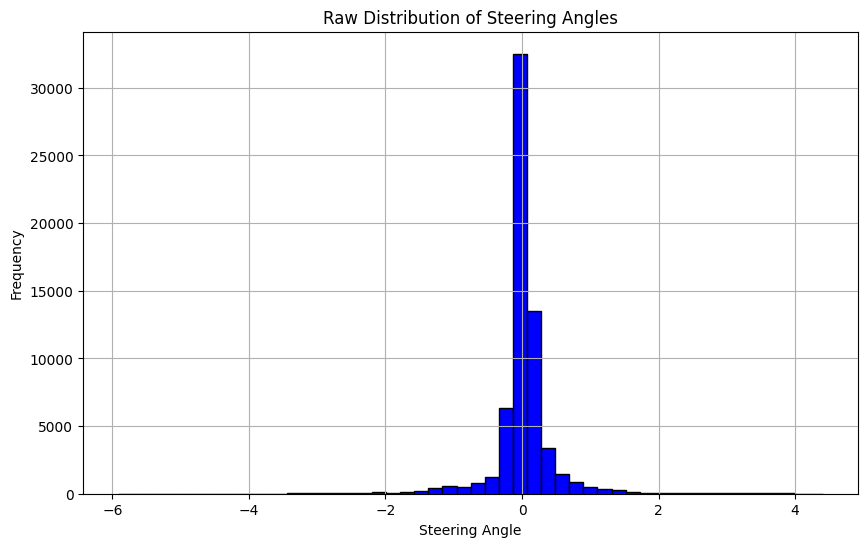

In [3]:
# Plot the distribution of steering angles
plt.figure(figsize=(10, 6))
plt.hist(steering_angles, bins=50, color='blue', edgecolor='black')

plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title('Raw Distribution of Steering Angles')
plt.grid(True)
plt.show()

In [4]:
# 80% train, 20% validation
split_index = int(len(filenames) * 0.8)  
train_filenames = filenames[:split_index]
val_filenames = filenames[split_index:]

# Dictionary to map each filename to its steering angle
labels = {filenames[i]: steering_angles[i] for i in range(len(filenames))}

print(f"Training samples: {len(train_filenames)}")
print(f"Validation samples: {len(val_filenames)}")

Training samples: 51060
Validation samples: 12765


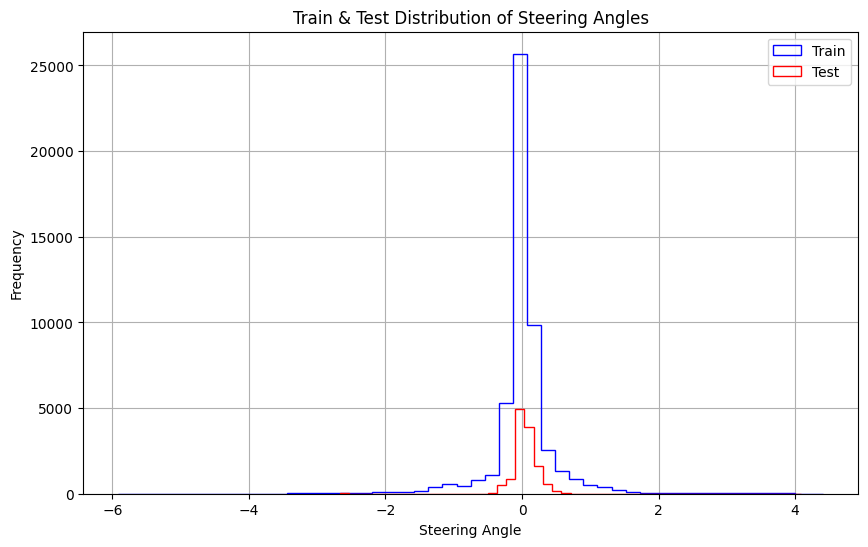

In [5]:
# Plot the distribution of steering angles split into training and testing data
plt.figure(figsize=(10, 6))
plt.hist(steering_angles[:split_index], bins=50, color='blue', histtype ='step',label='Train')
plt.hist(steering_angles[split_index:], bins=50, color='red', histtype ='step',label='Test')

plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title('Train & Test Distribution of Steering Angles')
plt.legend()
plt.grid(True)
plt.show()

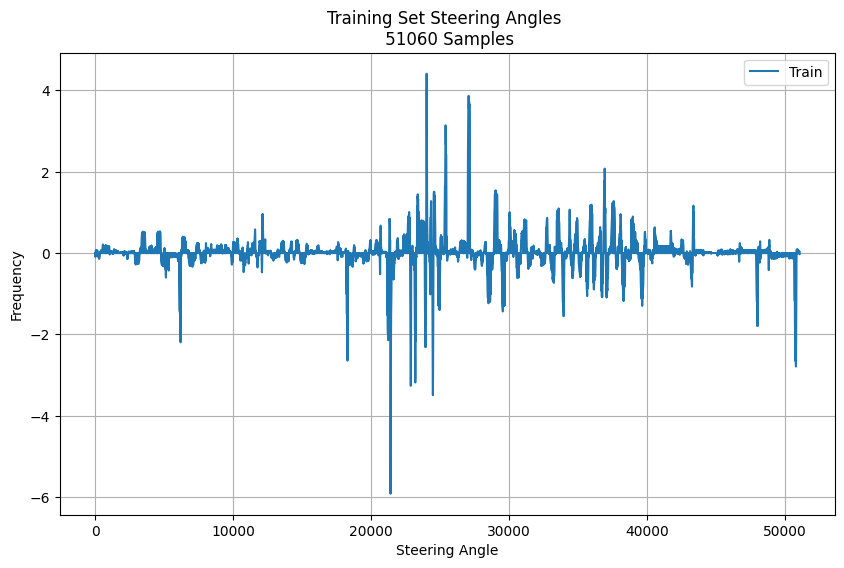

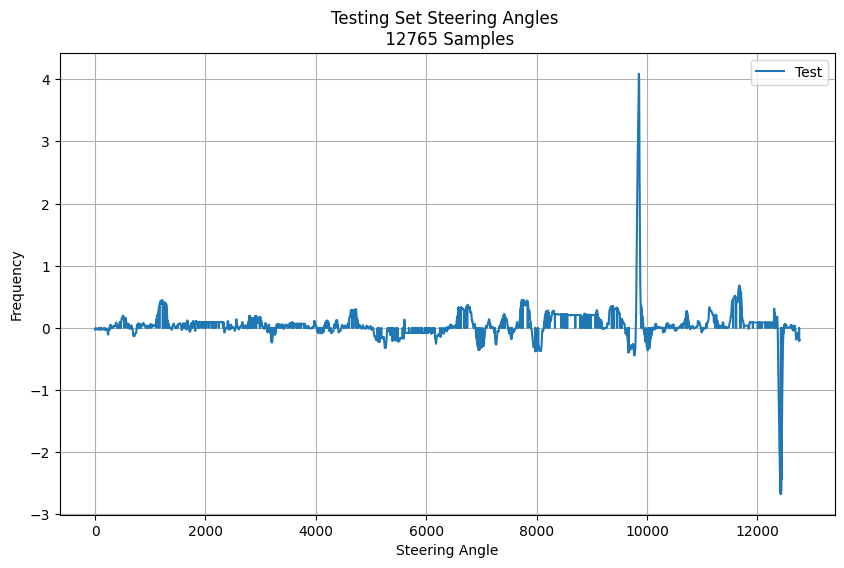

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(steering_angles[:split_index], label='Train')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title(f'Training Set Steering Angles \n {len(steering_angles[:split_index])} Samples')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steering_angles[split_index:], label='Test')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title(f'Testing Set Steering Angles \n {len(steering_angles[split_index:])} Samples')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes for the current batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        # Select file paths for the batch
        images_temp = [self.images[i] for i in indexes]
        # Generate data
        X, y = self.__data_generation(images_temp)
        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, images_temp):
        # Generates data containing batch_size samples
        X = []
        y = []
        for file_path in images_temp:
            # Read the image from disk
            image = cv2.imread(file_path)
            # Crop the bottom 150 rows and resize to (200,66)
            image = cv2.resize(image[-150:], (200, 66))
            # Normalize pixel values to [0,1]
            image = image / 255.0
            X.append(image)

            # Steering angle from the labels dict
            angle = self.labels[file_path]
            y.append(angle)

        return np.array(X), np.array(y)

In [8]:
import cv2, numpy as np, random
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(
        self, images, labels,
        batch_size=32, shuffle=True,
        augment=True,              # <- enable/disable on the fly
        rot_range=2,               # degrees (±) for small in-plane rotations
        flip_prob=0.5,
        bright_prob=0.5
    ):
        self.images      = images
        self.labels      = labels
        self.batch_size  = batch_size
        self.shuffle     = shuffle
        self.augment     = augment
        self.rot_range   = rot_range
        self.flip_prob   = flip_prob
        self.bright_prob = bright_prob
        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        idx = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        image_paths = [self.images[i] for i in idx]
        return self.__data_generation(image_paths)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # ---------- augmentation utilities ----------
    @staticmethod
    def _random_brightness(img, min_factor=0.4, max_factor=1.6):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsv[..., 2] = np.clip(hsv[..., 2] *
                              random.uniform(min_factor, max_factor), 0, 255)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    def _random_rotation(self, img):
        angle = random.uniform(-self.rot_range, self.rot_range)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)
        # Steering-angle compensation: camera rotations ≅ steering offsets,
        # use small factor; tweak to taste (1 deg ≈ 0.002 rad)
        steer_offset = np.deg2rad(angle) * 0.5
        return img, steer_offset

    # ---------- main batch assembly ----------
    def __data_generation(self, image_paths):
        X, y = [], []
        for p in image_paths:
            img  = cv2.imread(p)          # BGR
            ang  = self.labels[p]

            if self.augment:
                # Horizontal flip
                if random.random() < self.flip_prob:
                    img  = cv2.flip(img, 1)
                    ang  = -ang            # invert steering

                # Small rotation
                if random.random() < 0.5:
                    img, off = self._random_rotation(img)
                    ang += off

                # Brightness jitter
                if random.random() < self.bright_prob:
                    img = self._random_brightness(img)

            # Crop road only (bottom 150 rows) and resize for NVIDIA model
            img = cv2.resize(img[-150:], (200, 66))
            img = img[:, :, ::-1] / 255.0  # BGR→RGB, 0-1

            X.append(img.astype(np.float32))
            y.append(ang)

        return np.asarray(X), np.asarray(y).astype(np.float32)


In [9]:
def nvidia_model(input_shape=(66, 200, 3)):
    model = Sequential()
    # 5x5 Convolutional layers with stride 2x2
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='elu', input_shape=input_shape))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    # 3x3 Convolutional layers with stride 1x1
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.25))
    # Output layer
    model.add(Dense(1, activation='linear'))
    return model

In [10]:
def opt_nvidia_model(input_shape=(66, 200, 3), l2_reg=1e-4):
    model = Sequential()
    
    # 5x5 Conv layers with stride 2x2
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='elu',
                     kernel_regularizer=l2(l2_reg), input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())

    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())

    # 3x3 Conv layers with stride 1x1
    model.add(Conv2D(64, (3, 3), activation='elu',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='elu',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    # Fully connected layers with L2 + BatchNorm
    model.add(Dense(100, activation='elu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(50, activation='elu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(10, activation='elu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(1, activation='linear'))  

    print(model.summary)

    return model


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, SpatialDropout2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.regularizers import l2


def opt_nvidia_model_light(input_shape=(66, 200, 3),
                           l2_reg: float = 1e-4,
                           dropout_rate: float = 0.3) -> Sequential:
    """
    Leaner Sequential network for steering-angle prediction.
    • No cropping/normalisation (handled in the generator)
    • Three convolutional stages → GAP → two small dense layers
    """

    model = Sequential()

    # ----- 5×5 conv stem ----------------------------------------------------
    model.add(
        Conv2D(24, (5, 5), strides=(2, 2), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg),
               input_shape=input_shape)
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    model.add(
        Conv2D(36, (5, 5), strides=(2, 2), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg))
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    model.add(
        Conv2D(48, (3, 3), strides=(1, 1), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg))
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    # ----- global pooling & compact dense head -----------------------------
    model.add(Flatten())

    model.add(Dense(48, activation="elu", kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(16, activation="elu", kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="linear", name="steering"))

    # print callable, mimicking your original style
    print(model.summary)

    return model


In [12]:
train_generator = DataGenerator(train_filenames, labels, batch_size=32, shuffle=True)
val_generator = DataGenerator(val_filenames, labels, batch_size=32, shuffle=False)

reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=2,verbose=True)

early_stopping_monitor = EarlyStopping(patience=3, monitor='val_loss', mode='auto')

#model = opt_nvidia_model()
#model.compile(optimizer='adam', loss='mse', metrics =["accuracy"])

model = opt_nvidia_model_light()
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_generator, 
          epochs=5,
          validation_data=val_generator)



<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x0000025D009E88B0>>

Epoch 1/5


1595/1595 [==============================] - 184s 115ms/step - loss: 0.4887 - mae: 0.4190 - val_loss: 0.1181 - val_mae: 0.1523
Epoch 2/5
1595/1595 [==============================] - 176s 111ms/step - loss: 0.2625 - mae: 0.2565 - val_loss: 0.1176 - val_mae: 0.1647
Epoch 3/5
1595/1595 [==============================] - 177s 111ms/step - loss: 0.2507 - mae: 0.2477 - val_loss: 0.1329 - val_mae: 0.1803
Epoch 4/5
1595/1595 [==============================] - 176s 110ms/step - loss: 0.2520 - mae: 0.2452 - val_loss: 0.1464 - val_mae: 0.1923
Epoch 5/5
1595/1595 [==============================] - 177s 111ms/step - loss: 0.2583 - mae: 0.2422 - val_loss: 0.1533 - val_mae: 0.1773


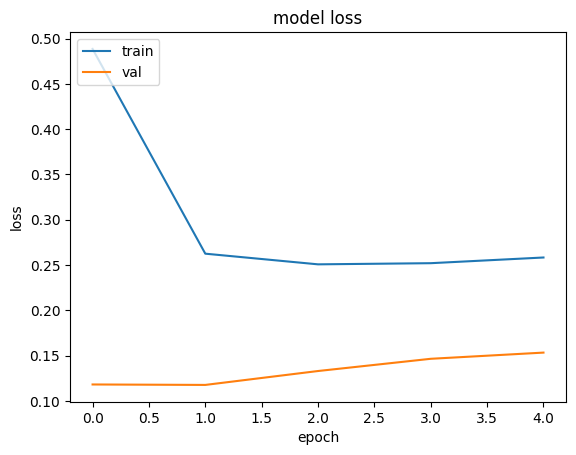

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
print(history.history)

{'loss': [0.48866957426071167, 0.2625167667865753, 0.250739723443985, 0.25201424956321716, 0.25829845666885376], 'mae': [0.4190126657485962, 0.2564810812473297, 0.24766308069229126, 0.2452491819858551, 0.24215194582939148], 'val_loss': [0.11806029081344604, 0.11756066232919693, 0.13291724026203156, 0.14641879498958588, 0.15326184034347534], 'val_mae': [0.15227462351322174, 0.16472633183002472, 0.18029144406318665, 0.19234460592269897, 0.17727810144424438]}


In [15]:
model.save("model.keras")
print("Model saved successfully to model.keras")
model.summary()

Model saved successfully to model.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 100, 24)       1800      
                                                                 
 batch_normalization (Batch  (None, 33, 100, 24)       96        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 33, 100, 24)       0         
                                                                 
 spatial_dropout2d (Spatial  (None, 33, 100, 24)       0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 50, 36)        21600     
                                                                 
 batch_normaliza

398/398 [==============================] - 2s 6ms/step
Validation MSE: 0.108051


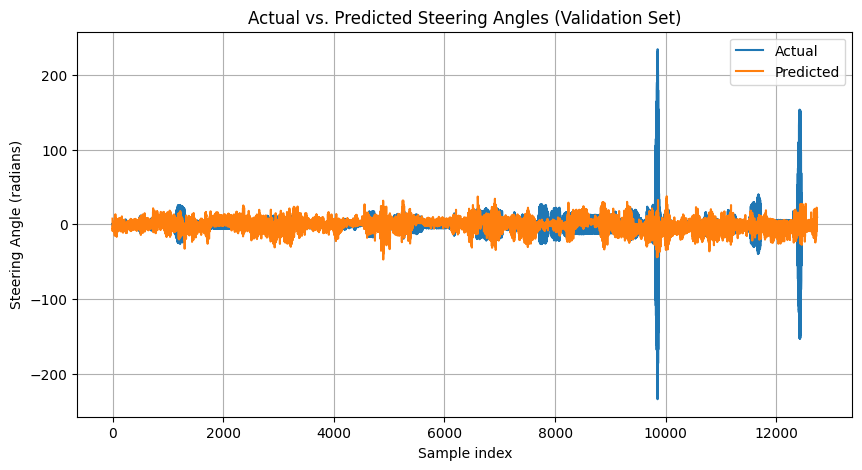

In [16]:
val_X = []
val_y_true = []
for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]  
    val_X.append(X_batch)
    val_y_true.append(y_batch)

val_X = np.concatenate(val_X, axis=0)
val_y_true = np.concatenate(val_y_true, axis=0)

val_y_pred = model.predict(val_X)
val_y_pred = val_y_pred.flatten()  

mse = mean_squared_error(val_y_true, val_y_pred)
print(f"Validation MSE: {mse:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(val_y_true * (180 / np.pi), label='Actual')
plt.plot(val_y_pred * (180 / np.pi), label='Predicted')
plt.title('Actual vs. Predicted Steering Angles (Validation Set)')
plt.xlabel('Sample index')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def get_img_array(img_path):

    image = cv2.imread(img_path)
    image = image[-150:]  # shape: (150, width, 3)
    image = cv2.resize(image, (200, 66))
    image = image / 255
    return np.expand_dims(image, axis=0)


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output, 
            model.output,                                  
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  
        steering_angle = predictions[:, 0]

    grads = tape.gradient(steering_angle, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #pooled_grads = tf.reduce_sum(tf.abs(grads), axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]  # remove batch dim => shape (h, w, channels)
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    max_val = np.max(heatmap) if np.max(heatmap) != 0 else 1e-10
    heatmap /= max_val


    return heatmap

def save_and_display_gradcam(img_path, heatmap, alpha=0.4, out_path="cam.jpg"):
    """
    Overlays a Grad-CAM heatmap on the original image and shows the result using matplotlib.

    Args:
        img_path (str): Path to the original image (for display).
        heatmap (np.ndarray): Grad-CAM heatmap in [0,1], shape possibly (h, w).
        alpha (float): Transparency factor for blending heatmap (0..1).
        out_path (str): Where to save the final overlay (in BGR format).
    """

    original_bgr = cv2.imread(img_path)

    # Convert to RGB for plotting
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (original_bgr.shape[1], original_bgr.shape[0]))
    # Convert heatmap to [0,255]
    heatmap_resized = np.uint8(255 * heatmap_resized)


    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_bgr = cv2.addWeighted(
        original_bgr, 1 - alpha,
        heatmap_color, alpha,
        0
    )

    # Convert back to RGB for display
    superimposed_rgb = cv2.cvtColor(superimposed_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(heatmap)
    plt.show()

    # 6. Display with matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(superimposed_rgb)
    axes[1].set_title("Grad-CAM Overlay")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Grad-CAM saved to {out_path}")


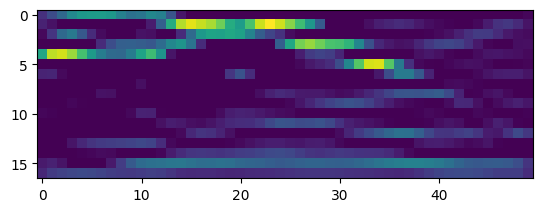

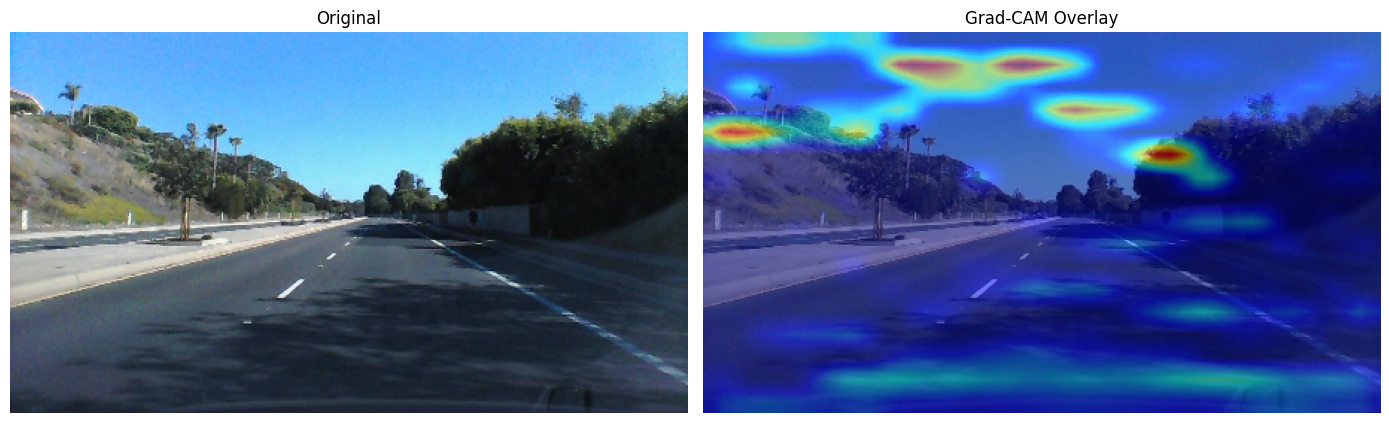

Grad-CAM saved to cam_overlay.jpg


In [18]:
last_conv_layer_name = "conv2d_2" 

# A sample image path (that the model sees in training format)
img_path = r"D:\07012018\data\0.jpg"

# 1) Convert the image to the correct input array
img_array = get_img_array(img_path)  # shape (1,66,200,3)

# 2) Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(
    img_array=img_array,
    model=model,
    last_conv_layer_name=last_conv_layer_name
)

# 3) Overlay heatmap and display
save_and_display_gradcam(img_path, heatmap, alpha=0.5, out_path="cam_overlay.jpg")

In [ ]:
# Select a convolutional layer
layer_name = 'conv2d_7'  # Change to the layer you want to visualize
layer = model.get_layer(name=layer_name)

# Get the weights of the layer
filters, biases = layer.get_weights()

# Normalize filter values for better visualization
filters_min = filters.min()
filters_max = filters.max()
filters = (filters - filters_min) / (filters_max - filters_min)

# Plot filters
n_filters = min(filters.shape[3], 16)  # Show up to 16 filters
fig, axes = plt.subplots(1, n_filters, figsize=(20, 5))

for i in range(n_filters):
    f = filters[:, :, :, i]  # Extract i-th filter
    f = f[:, :, 0]  # If it's RGB, take one channel
    
    axes[i].imshow(f, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i}')

plt.show()
